In [3]:
import numpy as np
import scipy as sp
import pandas as pd
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA

import time

import logistic_regression as LR
import first_order_method as FOM

import sys
sys.path.insert(0, '/Users/HKim/Desktop/Research/Experiments/libsvm-weights-3.20/python')
from svm import *
from svmutil import *

In [4]:
pd.read_csv('../dataset/original/dataset_statistics.csv')

,file name,# samples (before removing empty rows),# samples (after removing empty rows),# features,classes,# classes,normalized,sparse,comment
0,news20.binary,19996,19954,1355191,"[1.0, -1.0]",2,1,1,NaN
1,covtype.libsvm.binary,581012,581012,54,"[1.0, 2.0]",2,0,1,NaN
2,covtype.libsvm.binary.scale,581012,581012,54,"[1.0, 2.0]",2,0,1,Different from covtype.binary: every feature i...
3,real-sim,72309,72201,20958,"[1.0, -1.0]",2,1,1,NaN
4,rcv1_train.binary,20242,20242,47236,"[1.0, -1.0]",2,1,1,NaN
5,rcv1_test.binary,677399,677399,47236,"[1.0, -1.0]",2,1,1,NaN


In [5]:
def compute_2norm_row(X):
    X_tmp = X.copy()
    X_tmp.data **= 2
    norm_y = sp.sqrt(X_tmp.sum(1))
    return sp.sqrt(X_tmp.sum(1))

In [6]:
def normalize_row(X):
    row_norm = compute_2norm_row(X)
    return sp.sparse.diags([1.0/n[0] for n in row_norm])*X

In [7]:
def data_parsing(X,y):
#     # Removing empty data
#     empty_idx = []
#     for i in xrange(len(X)):
#         if len(X[i].keys()) == 0:
#             empty_idx.append(i)
#             continue
#     n_deleted = 0
#     for idx in empty_idx:
#         del X[idx-n_deleted]
#         del y[idx-n_deleted]
#         n_deleted += 1

    # The number of samples
    n_samples = len(X)

    # Feature dimension
    dim = max([max(xi.keys()) for xi in X])
    
    # Convert to a scipy sparse row matrix
    XX = sp.sparse.dok_matrix((n_samples,dim), dtype=float)
    for i in xrange(len(X)):
        for key in X[i].keys():
            j = key-1
            XX[i,j] = X[i][key]
    XX = XX.tocsr()
    
    # Normalize feature vectors
#     XX = normalize_row(XX)
    return XX, y

In [8]:
# def main():
# Read the data
y_trn, X_trn = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_train.binary')
# y_tst, X_tst = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_test.binary')

In [9]:
X_trn, y_trn = data_parsing(X_trn, y_trn)
# X_tst, y_tst = data_parsing(X_tst, y_tst)

# The number of samples
n_sample = X_trn.shape[0]

In [10]:
# Generate the problem: Logistic-regression
data = {'X_train':X_trn, 'y_train':y_trn}#, 'X_test': X_tst, 'y_test': y_tst}
parameters = {"lambda":2.0/n_sample}
problem = LR.BinaryLogisticRegression(data, parameters)

In [11]:
param_method = {"step-size":1e-3, "# max-pass":100, "epsilon":1e-3,
                "result_stored":{'trn_loss':True,'tst_loss':False,'trn_err':True,'tst_err':False,
                                 'norm_grad':True,'n_grad_comp':True}}

In [12]:
# Generate the problem: Logistic-regression
problem = LR.BinaryLogisticRegression(data, parameters)

tic = time.time()
param_method['step-size'] = 10
# Full gradient
fgd = FOM.FirstOrderMethod(problem, 'fgd', param_method)
# Do optimization
fgd.do_optimization()
# print fgd.get_result("trn_loss")
print time.time()-tic

2.15321302414


In [ ]:
# Generate the problem: Logistic-regression
problem = LR.BinaryLogisticRegression(data, parameters)

tic = time.time()
param_method['step-size'] = 1
# SVRG (m=n)
svrg = FOM.FirstOrderMethod(problem, 'svrg', param_method)
svrg.set_epoch_size(problem.get_n_sample())
# Do optimization
svrg.do_optimization()
# print svrg.get_result('norm_grad')
print time.time()-tic

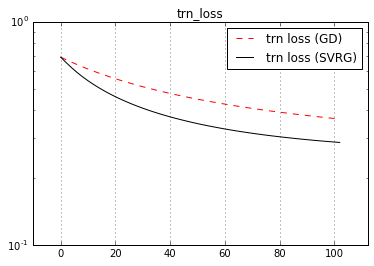

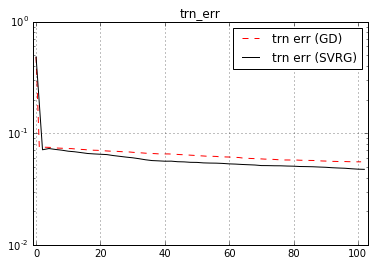

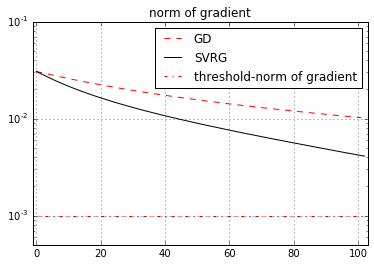

In [25]:
x_gd = [pass_/float(n_sample) for pass_ in fgd.get_result('n_grad_comp')]
x_svrg = [pass_/float(n_sample) for pass_ in svrg.get_result('n_grad_comp')]

# Loss
plt.figure()
plt.semilogy(x_gd, fgd.get_result('trn_loss'), 'r--',label='trn loss (GD)')
plt.semilogy(x_svrg, svrg.get_result('trn_loss'), 'k-',label='trn loss (SVRG)')
# plt.semilogy(x_gd, fgd.get_result('tst_loss'), 'b-',label='tst loss (GD)')
plt.legend()
plt.xlim(-0.1*max(x_gd[-1],x_svrg[-1]),1.1*max(x_gd[-1],x_svrg[-1]))
plt.grid()
plt.title('trn_loss')

# Error
plt.figure()
plt.semilogy(x_gd, fgd.get_result('trn_err'), 'r--',label='trn err (GD)')
plt.semilogy(x_svrg, svrg.get_result('trn_err'), 'k-',label='trn err (SVRG)')

# plt.semilogy(x_gd, fgd.get_result('tst_err'), 'b-',label='tst err (GD)')
plt.legend()
plt.xlim([-0.01*max(x_gd[-1], x_svrg[-1]),1.01*max(x_gd[-1], x_svrg[-1])])
plt.grid()
plt.title('trn_err')

# Norm of gradient
plt.figure()
plt.semilogy(x_gd, fgd.get_result('norm_grad'), 'r--',label='GD')
plt.semilogy(x_svrg, svrg.get_result('norm_grad'), 'k-',label='SVRG')
plt.semilogy([-0.1*max(x_gd[-1],x_svrg[-1]),1.1*max(x_gd[-1],x_svrg[-1])],
             [param_method['epsilon'],param_method['epsilon']], 'r-.',label='threshold-norm of gradient')
plt.legend()
plt.xlim([-0.01*max(x_gd[-1], x_svrg[-1]),1.01*max(x_gd[-1], x_svrg[-1])])
plt.ylim(bottom=param_method['epsilon']/2)
plt.grid()
plt.title('norm of gradient')

In [23]:
1


[-1.02, 103.02]

In [142]:
param_method['epsilon']

0.001

In [ ]:
param_method['step-size'] = 1e-4
# Stochastic gradient
sgd = FOM.FirstOrderMethod(problem, 'sgd', param_method)
# Do optimization
sgd.do_optimization()

In [ ]:
param_method['step-size'] = 1e-5
# SVRG
svrg = FOM.FirstOrderMethod(problem, 'svrg', param_method)
svrg.set_epoch_size(problem.get_n_sample())
# Do optimization
svrg.do_optimization()

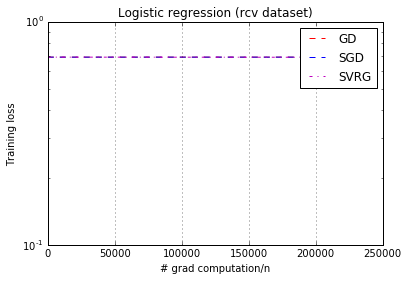

In [14]:
# Plot the results
# Plot the rate of convergence
plt.figure()
plt.semilogy(fgd.get_result("n_grad_comp"), fgd.get_result("trn_loss"),
             'r--',label='GD')
plt.semilogy(sgd.get_result("n_grad_comp"), sgd.get_result("trn_loss"),
             'b--',label='SGD')
plt.semilogy(svrg.get_result("n_grad_comp"), svrg.get_result("trn_loss"),
             'm-.',label='SVRG')

# plt.semilogy(n_comp_grad_pim["2N"], obj_val_svrg["2N"],'m-',label='SVRG (m=2N)')
# plt.semilogy(n_comp_grad_pim["N"],  obj_val_svrg["N"],'r-',label='SVRG (m=N)')
# plt.semilogy(n_comp_grad_pim["N/2"], obj_val_svrg["N/2"],'b-',label='SVRG (m=N/2)')
# plt.semilogy(n_comp_grad_pim["N/4"], obj_val_svrg["N/4"],'k-',label='SVRG (m=N/4)')
# plt.semilogy(n_comp_grad_pim["N/8"], obj_val_svrg["N/8"],'g-',label='SVRG (m=N/8)')
plt.xlabel('# grad computation/n')
plt.ylabel('Training loss')
plt.title('Logistic regression (rcv dataset)')
plt.legend()
plt.grid()
plt.show()

In [43]:
if __name__ == '__main__':
    main()